<a href="https://colab.research.google.com/github/previoip/py-bachelor-thesis-data-analysis-redo/blob/main/Tensile_Test_Data_fin_post_proc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PLA-CNT Carbon Nanotube Tensile Result Recalculation
#### auth: Previo Prakasa
#### date: 14/04/2022

---

## Data Preparation

---


In [152]:
DATA_URL = "https://drive.google.com/drive/folders/1KfyUpcXIJjVQSM0pqQQZXb7rn4tzuNSv?usp=sharing"
DATA_OUTPUT_PATH = "data"
EXPORT_OUTPUT_PATH = "export"
PURGE_LOCAL_DATA = False
SAVE_AND_DOWNLOAD_FIGURES = True

In [153]:
# Missinf deps
!pip install --upgrade xlrd
!pip install --upgrade --no-cache-dir gdown

In [154]:
# Initialize env
import os, shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as prect
import numpy as np
import pandas as pd
import xlrd
from google.colab import files

for z in os.listdir('.'):
  if z[-3:] == 'zip':
    print('removed:', z)
    os.remove(z)

# print(os.listdir('.'))
if PURGE_LOCAL_DATA:
  if os.path.exists(DATA_OUTPUT_PATH):
    print('removed:', DATA_OUTPUT_PATH)
    shutil.rmtree(DATA_OUTPUT_PATH)
  else:
    os.mkdir(DATA_OUTPUT_PATH)

  if os.path.exists(EXPORT_OUTPUT_PATH):
    print('removed:', EXPORT_OUTPUT_PATH)
    shutil.rmtree(EXPORT_OUTPUT_PATH)
  else:
    os.mkdir(EXPORT_OUTPUT_PATH)

if not os.path.exists(DATA_OUTPUT_PATH):
  os.mkdir(DATA_OUTPUT_PATH)

if not os.path.exists(EXPORT_OUTPUT_PATH):
  os.mkdir(EXPORT_OUTPUT_PATH)


In [155]:
# Download tensile dataset if not exist

import gdown

data_list = []

if os.path.exists(DATA_OUTPUT_PATH):
  data_list = sorted([os.path.join(DATA_OUTPUT_PATH, i) for i in os.listdir(DATA_OUTPUT_PATH) if i != ".ipynb_checkpoints"])
  print('excel data found on local')
  for d in data_list:
    print('-',d)

if not os.path.exists(DATA_OUTPUT_PATH) or not data_list:
  _ = gdown.download_folder(url=DATA_URL, output=DATA_OUTPUT_PATH, use_cookies = False, speed=256*1024)
  # _ = gdown.download(id=DATA_URL_ID, output='.')
  data_list = sorted([os.path.join(DATA_OUTPUT_PATH, i) for i in os.listdir(DATA_OUTPUT_PATH) if i != ".ipynb_checkpoints"])
  print('excel data downloaded')
  for d in data_list:
      print('-',d)

if not data_list:
  raise ValueError("data_list is empty")

excel data found on local
- data/PLA Sample 1.xls
- data/PLA Sample 2.xls
- data/PLA Sample 3.xls
- data/PLA Sample 4.xls
- data/PLA Sample 5.xls
- data/PLA+CNT Sample 1.xls
- data/PLA+CNT Sample 2.xls
- data/PLA+CNT Sample 3.xls
- data/PLA+CNT Sample 4.xls


In [156]:
# check data_list 
data_list

['data/PLA Sample 1.xls',
 'data/PLA Sample 2.xls',
 'data/PLA Sample 3.xls',
 'data/PLA Sample 4.xls',
 'data/PLA Sample 5.xls',
 'data/PLA+CNT Sample 1.xls',
 'data/PLA+CNT Sample 2.xls',
 'data/PLA+CNT Sample 3.xls',
 'data/PLA+CNT Sample 4.xls']

---

## Tensile Data Container Class

---


In [157]:
# dataframe wrapper class

class TensileDataFrame:
  def __init__(self, name: str, df: pd.DataFrame, filepath: str, specimen_type: str = ''):
    self.name = name
    self.df = df
    self.filepath = filepath
    self.specimen_type = specimen_type
    self.statistics = {
        'Elongation' : None, 
        'Force' : None, 
        'Et' : None, 
        'Et_calc' : None, 
        'sY' : None, 
        'sY_calc' : None,
        'eY_calc' : None,
        'sM' : None, 
        'eM' : None, 
        'sB' : None, 
        'eB' : None, 
        'h' : None, 
        'b' : None, 
        'A0': None
    }
    self.__st_unit = ['mm', 'N', 'MPa', 'MPa', 'MPa','MPa', '%', 'MPa', '%', 'MPa', '%', 'mm', 'mm', 'mm²']
    self.statistics_unit_ref = dict(zip(self.statistics.keys(), self.__st_unit))

  def append_statistics(self, key, value):
    if key in self.statistics:
      self.statistics[key] = value

  def __repr_stats(self):
    return '\n\t - ' + '\n\t - '.join([f'{a} ({self.statistics_unit_ref[a]})\t: {b}' for a,b in self.statistics.items()])

  def get_summary(self) -> None:
    print(self.__repr__())

  def __repr__(self):
    return f"""
    DF filepath: {self.filepath}
    DF Name: {self.name}
    DF Pre-Calculated Statistics: {self.__repr_stats()}
    DF Head: {self.df.head}\n\n
    """

In [158]:
df_collection = []

# data extraction
for d_file in data_list:

  d_name = d_file.split(os.sep)[-1]
  d_fformat = d_name.split('.')[-1]
  d_name = d_name.split('.')[0]
  d_name = d_name.split(' ')
  d_spec_type = d_name[0]
  d_name = ' '.join(d_name)

  d_data = None
  d_data_temp_statisticsSheet = None

  if d_fformat == 'xls':
    # xls format refer to xlrd 
    d_tempWorkbook =  xlrd.open_workbook(d_file)
    d_tempSheet = d_tempWorkbook.sheet_by_name([i for i in d_tempWorkbook.sheet_names() if i.startswith('Specimen')][0])
    d_data = [d_tempSheet.row_values(r) for r in range(d_tempSheet.nrows)]

    if 'Statistics' in d_tempWorkbook.sheet_names():
      d_tempSheet_Statistics = d_tempWorkbook.sheet_by_name('Statistics')
      d_data_temp_statisticsSheet = [d_tempSheet_Statistics.row_values(r) for r in range(d_tempSheet_Statistics.nrows)]
      d_data_temp_statisticsSheet = np.array([d_data_temp_statisticsSheet[0][1:], d_data_temp_statisticsSheet[2][1:]]).T # Statistics sheet transposed

  elif d_fformat == 'xlsx':
    # xlsx format refer to pd.read_excel 
    # df_read = pd.read_excel(d_file, sheet_name='Sheet1')
    # df_read = pd.read_excel(d_file)
    pass

  if not d_data:
    raise ValueError('No Source Data Found')

  # data cleanup    
  d_data_head = d_data[1]
  d_data_rows = d_data[3:]
  df_temp = pd.DataFrame(d_data_rows, columns=['Strain', 'Stress'])
  df_dataframe = TensileDataFrame(name = d_name, df = df_temp, filepath = d_file, specimen_type=d_spec_type)
  # if d_data_temp_statisticsSheet:
  if 'Statistics' in d_tempWorkbook.sheet_names():
    for metric in d_data_temp_statisticsSheet:
      df_dataframe.append_statistics(metric[0], float(metric[1]))

  df_collection.append(df_dataframe)

In [159]:
print('\n'.join(['- '+i.name for i in df_collection]))

- PLA Sample 1
- PLA Sample 2
- PLA Sample 3
- PLA Sample 4
- PLA Sample 5
- PLA+CNT Sample 1
- PLA+CNT Sample 2
- PLA+CNT Sample 3
- PLA+CNT Sample 4


In [160]:
# show parsed dataframe summary

import random
df_collection[random.randint(0, len(df_collection)-1)].get_summary()


    DF filepath: data/PLA+CNT Sample 4.xls
    DF Name: PLA+CNT Sample 4
    DF Pre-Calculated Statistics: 
	 - Elongation (mm)	: 2.8306212425231934
	 - Force (N)	: 1039.857421875
	 - Et (MPa)	: 1221.9485914226568
	 - Et_calc (MPa)	: None
	 - sY (MPa)	: 40.12352880319026
	 - sY_calc (MPa)	: None
	 - eY_calc (%)	: None
	 - sM (MPa)	: 40.12352880319026
	 - eM (%)	: 4.3682098388671875
	 - sB (MPa)	: 37.88029769819979
	 - eB (%)	: 5.258609771728516
	 - h (mm)	: 4.14
	 - b (mm)	: 6.26
	 - A0 (mm²)	: 25.916399999999996
    DF Head: <bound method NDFrame.head of       Strain     Stress
0   0.000000   0.280704
1   0.013085   0.420734
2   0.031031   0.619896
3   0.047628   0.822537
4   0.058710   1.048273
..       ...        ...
95  4.648539  39.931011
96  4.764163  39.755982
97  4.895081  39.476106
98  5.049579  39.012040
99  5.258610  37.880298

[100 rows x 2 columns]>


    


---

## Tensile Yield point and Modulus Young re-calculation function from first derivative polyfit

---

Since the dataset obtained from tensile test result shows discrepancy in modulus young obtained from the test apparatus (being tensile yield having same value as ultimate yield), post processing is required to evaluate modulus young value




In [161]:
MAX_ERROR = .005
N_ITER = 10000

In [162]:
# detect stress-strain graph linearity using marching linear regression

def detect_linearity_with_lin_reg(df_x, df_y, discrete_iter=1000, maxerr = 0.1, showplot = False, verbose=False, plotname=''):
  reversed = True
  plot_on_index = []
  if showplot and discrete_iter > 20:
    plot_on_index = [int(i) for i in np.linspace(0, discrete_iter, 20)]
  else:
    plot_on_index = [i for i in range(20)]

  df_x, df_y = np.array(df_x), np.array(df_y)
  # create polyfit approx of the initial x y data and turn it into function with degree 5
  polyfit_func = np.poly1d(np.polyfit(df_x, df_y, deg=5))

  x_start, x_stop, y_start, y_stop = df_x[0], df_x[-1], df_y[0], 0
  x_linsp = np.linspace(x_start, x_stop, discrete_iter)
  
  std_mean_err = 0
  if reversed:
    x_linsp = np.linspace(x_stop, x_start, discrete_iter)
    std_mean_err = 1

  num_iter = 0
  x_range_fin = None
  for x_id, x_sample in enumerate(x_linsp):
    if x_id > 1:
      x_range = np.linspace(x_start, x_sample, x_id)
      if reversed:
        x_range = np.linspace(x_start, x_sample, len(x_linsp) - x_id)
        
      # lin_polyfit_func = np.poly1d(np.polyfit([x_start, x_sample],[y_start, polyfit_func(x_sample)], deg=1))
      lin_polyfit_func = np.poly1d(np.polyfit(x_range, polyfit_func(x_range), deg=1))
      x_range_fin = x_range
      num_iter = x_id
      lin_curve = lin_polyfit_func(x_range)
      approx_curve = polyfit_func(x_range) 
      diff = lin_curve - approx_curve 

      # std_mean_err = np.std(diff) / np.sqrt(np.size(diff)) 
      std_mean_err = np.std(diff) / np.sqrt(np.size(diff)) 

      def plot_handler():
          fig, ax = plt.subplots(2,1, sharex=True, figsize = (8,6), gridspec_kw={'height_ratios': [3, 1]})
          figtitle_str = f'n iter: {x_id} \nstd_mean_err: {std_mean_err:.8f}'
          if plotname:
            figtitle_str = f'{plotname}\n {figtitle_str}'

          ax[0].set_title(figtitle_str)
          ax[0].plot(x_range, lin_curve, label='Linear Approx, marching')
          ax[0].plot(x_range, approx_curve, label='Polyfit Approx strain-stress')
          ax[0].plot(df_x, df_y, label='Actual', linestyle=':')
          
          ax[1].plot(x_range, diff, label='Difference')
          ax[1].fill_between(x_range, diff, color='#539ecd', hatch='///')
          
          # plt.plot(x_range, lin_curve, label='Linear Approx, marching')
          # plt.plot(x_range, approx_curve, label='Polyfit Approx strain-stress')
          # plt.plot(x_range, diff, label='Difference')
          # plt.plot(df_x, df_y, label='Actual', linestyle=':')

          # plt.fill_between(x_range, diff, color='#539ecd', hatch='///')
          # plt.title(f'num iter: {x_id} \nstd_mean_err: {std_mean_err:.8f}')
          plt.show()


      if verbose:
        print(f'calculating... current std mean error {std_mean_err}')
      if showplot:
        if x_id in plot_on_index:
          plot_handler()
      if (std_mean_err >= maxerr and x_id > discrete_iter/5 and not reversed) or (std_mean_err <= maxerr and reversed):  
        if verbose:
          print(f'done! with std mean error {std_mean_err}')
        if showplot:
          plot_handler()
        break

  return [std_mean_err, num_iter, diff, lin_curve], [x_range_fin, polyfit_func(x_range_fin)]

PLA Sample 1


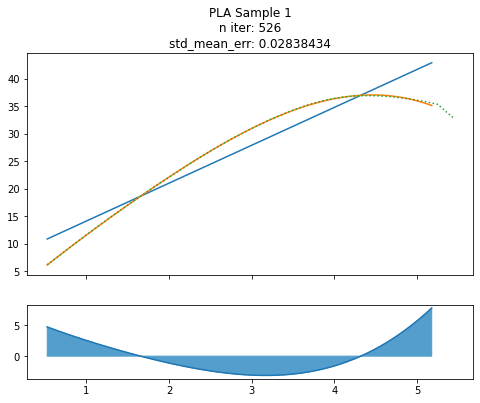

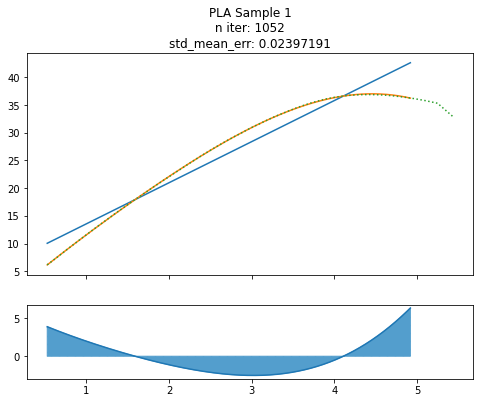

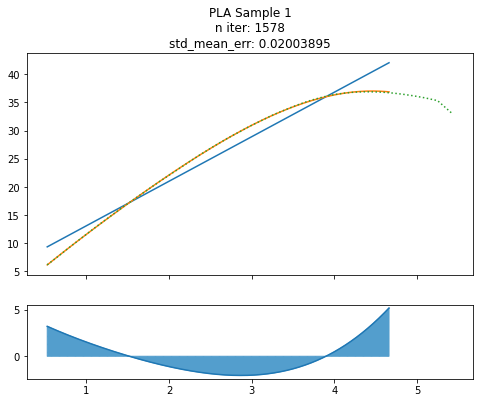

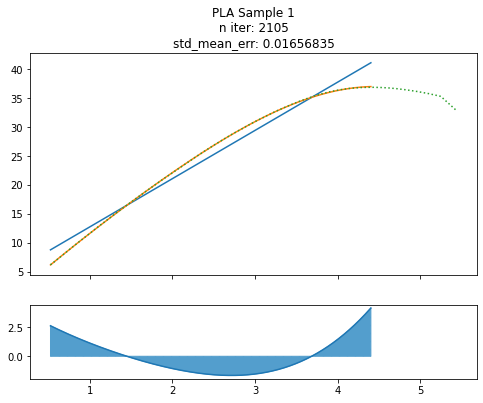

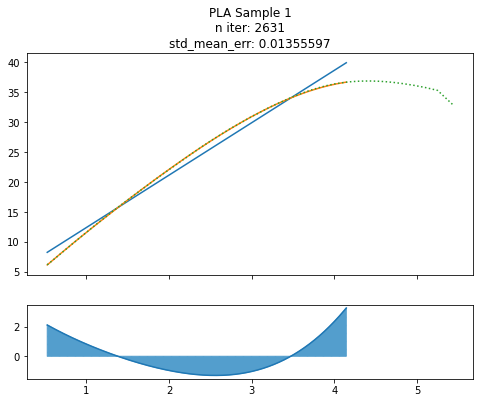

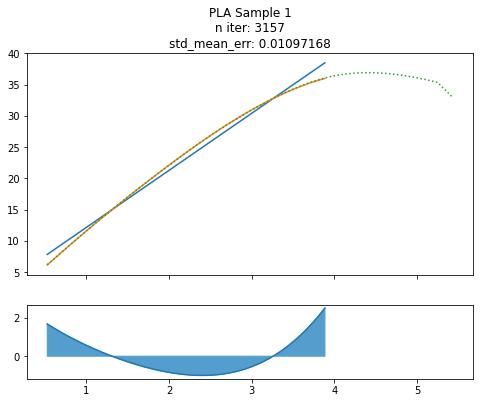

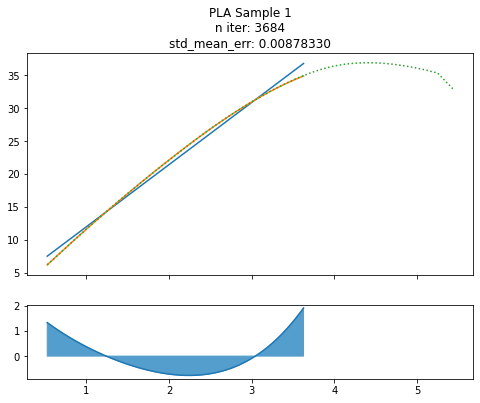

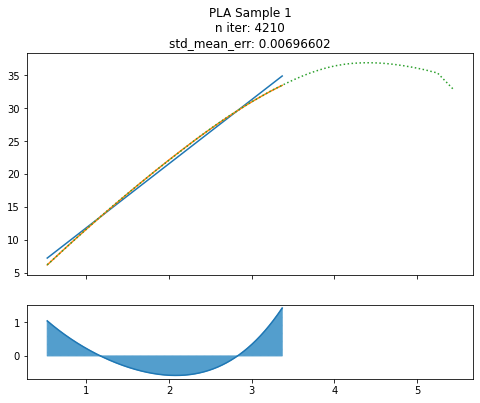

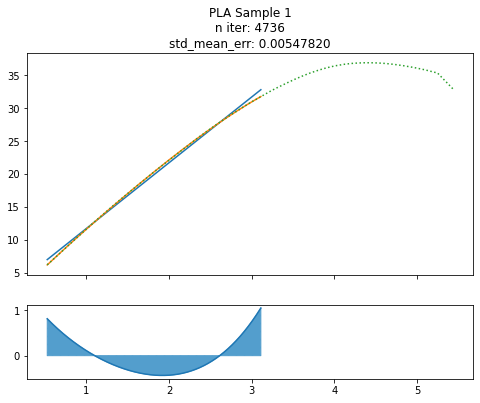

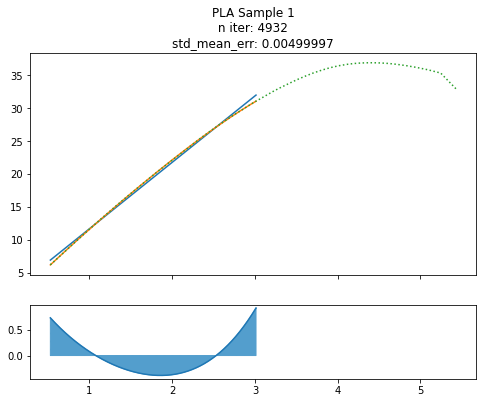

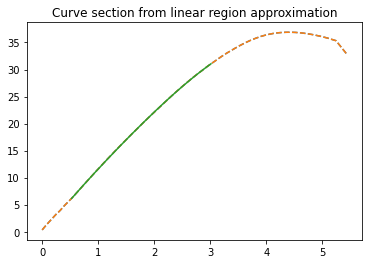

In [163]:
# Test with preexisting df

test_df = df_collection[0]
dfname = test_df.name 
print(dfname)
# threshold = test_df.statistics['eM'] * .025
threshold = .5
test_df = test_df.df


er, lin = detect_linearity_with_lin_reg(
    test_df.Strain[test_df.Strain > threshold], 
    test_df.Stress[test_df.Strain > threshold], 
    N_ITER, 
    maxerr=MAX_ERROR, 
    showplot=True, 
    verbose=False,
    plotname=dfname
    )
plt.plot(test_df.Strain, test_df.Stress, label="Actual", linestyle='--')
plt.plot(test_df.Strain, test_df.Stress, label="Actual", linestyle='--')
plt.plot(lin[0], lin[1], label="predict")
plt.title("Curve section from linear region approximation")
plt.show()

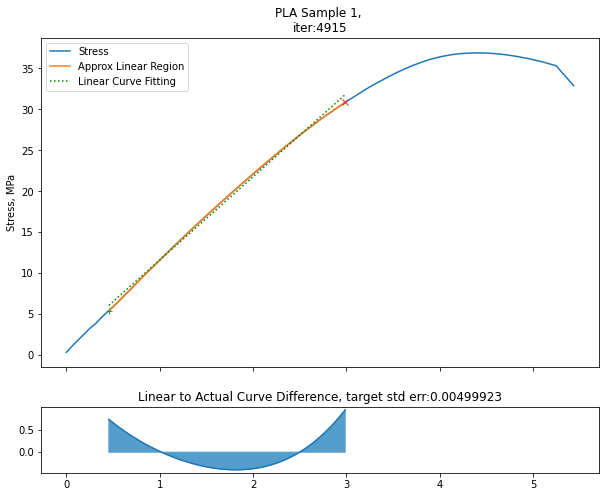

final yield point eY:2.986812415395988 sY:30.856166296806734




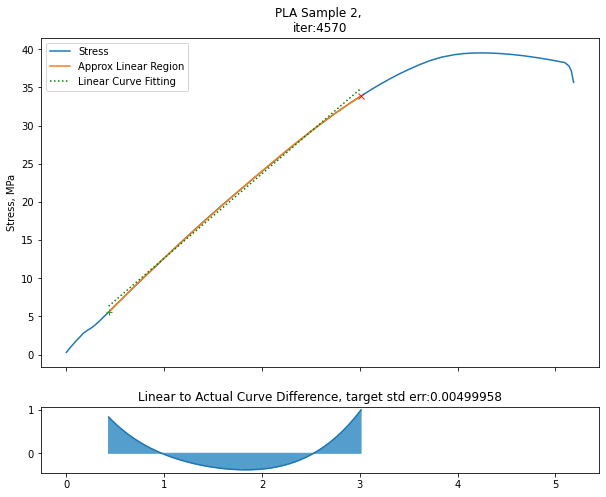

final yield point eY:3.0127990755632155 sY:33.89440140229803




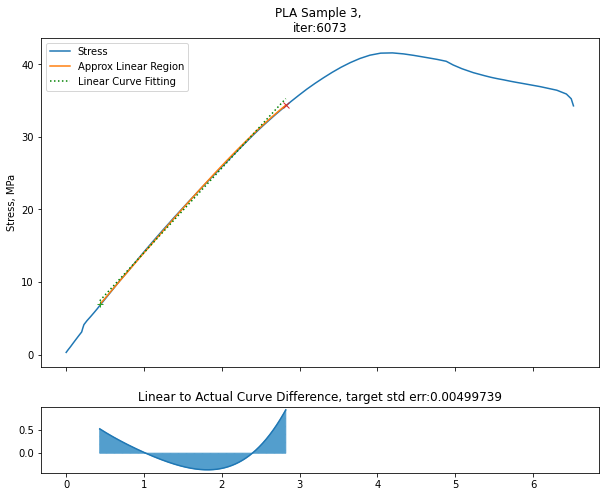

final yield point eY:2.822370298257702 sY:34.35891683850054




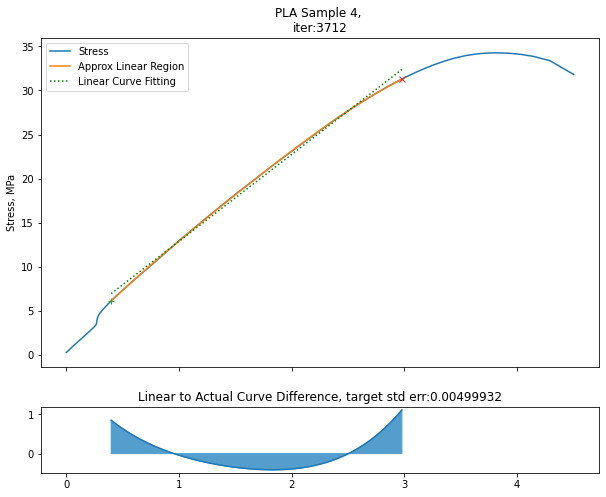

final yield point eY:2.979039686203275 sY:31.268293732439304




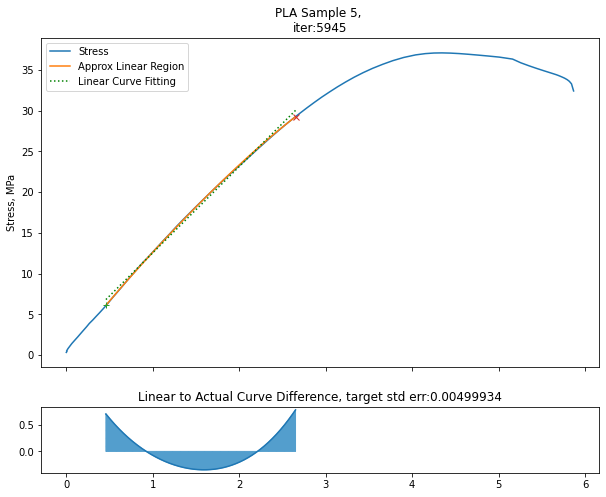

final yield point eY:2.650823787878004 sY:29.25320825222877




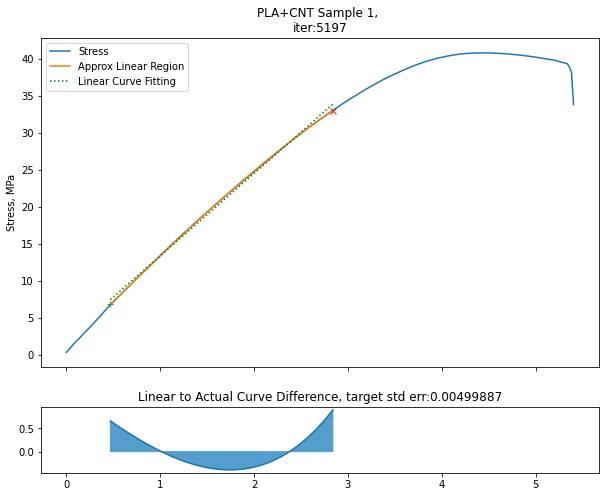

final yield point eY:2.8399457876028613 sY:33.026311374005765




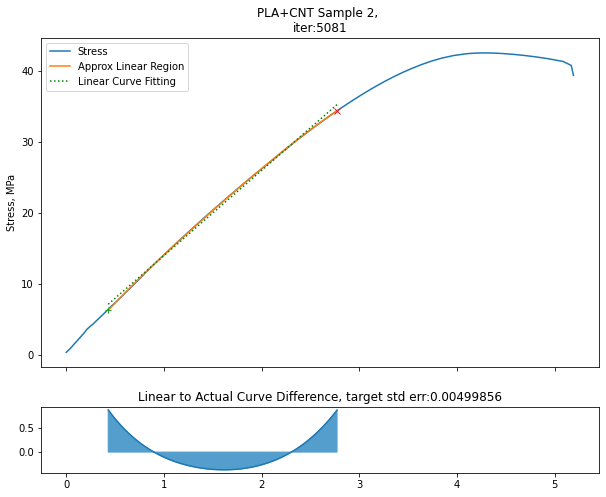

final yield point eY:2.7715532732755253 sY:34.39907417264566




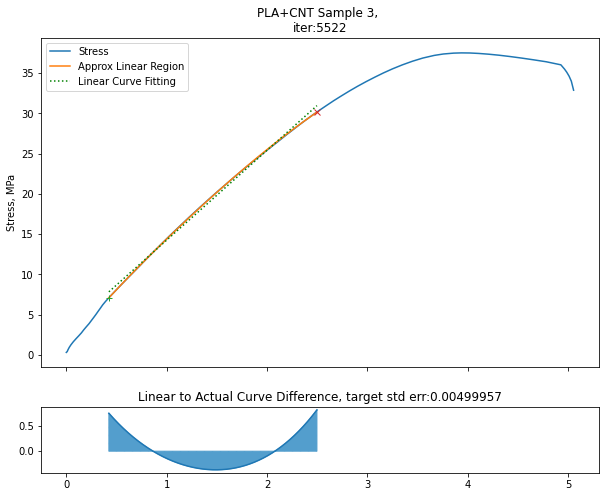

final yield point eY:2.497585533135803 sY:30.150760354348932




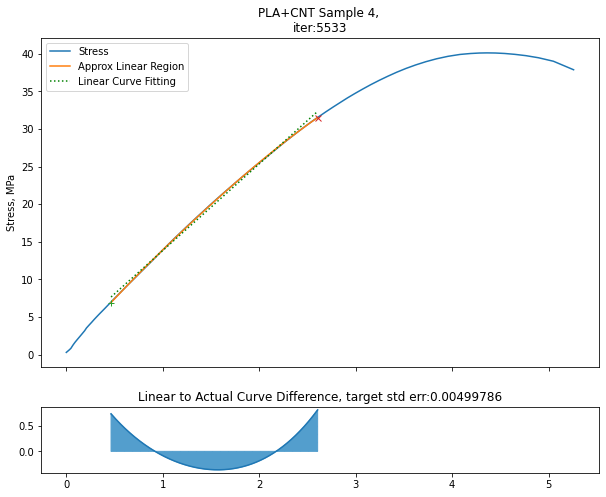

final yield point eY:2.6053243921545794 sY:31.526447430700415




In [164]:
threshold = .5
figsize = (10, 8)

subfolder = 'temp_grad_plot_eval'

if not os.path.exists(os.path.join(EXPORT_OUTPUT_PATH, subfolder)):
  os.mkdir(os.path.join(EXPORT_OUTPUT_PATH, subfolder))

for df_item in df_collection:


  threshold = df_item.statistics['eM'] * .1

  fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': (5,1)}, figsize=figsize)  

  # set source data plt
  # plt1 = ax.plot(df_item.df.Strain, df_item.df.Stress, label='Actual')
  df_item.df.plot(
      ax=ax[0],
      x='Strain',
      xlabel='Strain, %', 
      ylabel='Stress, MPa', 
      # title= f'{i_df.name} Stress-Strain Graph', 
      # figsize=figsize,
      legend=False
  )
  # trucate to remove initial noisy values

  trunc_strain = df_item.df.Strain[df_item.df.Strain > threshold]
  trunc_stress = df_item.df.Stress[df_item.df.Strain > threshold]

  trunc_strain_residue = df_item.df.Strain[df_item.df.Strain <= threshold]
  trunc_stress_residue = df_item.df.Stress[df_item.df.Strain <= threshold]

  err, linear_region = detect_linearity_with_lin_reg(trunc_strain, trunc_stress, N_ITER, maxerr=MAX_ERROR)
  
  # linear region approx
  ax[0].plot(linear_region[0], linear_region[1], label='Approx Linear Region')

  ax[0].plot([linear_region[0][0]], [linear_region[1][0]], marker='+')
  ax[0].plot([linear_region[0][-1]], [linear_region[1][-1]], marker='x')

  ax[0].plot(linear_region[0], err[3], linestyle=':', label='Linear Curve Fitting', c='g')

  ax[0].legend(loc='best')
  ax[0].set_title(f"{df_item.name}, \niter:{err[1]}")


  ax[1].plot(linear_region[0], err[2])
  ax[1].fill_between(linear_region[0], err[2], color='#539ecd', hatch='///')

  ax[1].set_title(f"Linear to Actual Curve Difference, target std err:{err[0]:.8f}")

  # calculate yield strain, stress, and modulus young
  # plt.plot(eY_calculated[0], sY_calculated[0], marker='o')
  eY_calculated = linear_region[0][-1]
  sY_calculated = linear_region[1][-1]


  if SAVE_AND_DOWNLOAD_FIGURES:
    plt.savefig(os.path.join(EXPORT_OUTPUT_PATH, subfolder, f'Linear to Actual Curve {df_item.name}'), dpi=300)
  plt.show()

  print(f'final yield point eY:{eY_calculated} sY:{sY_calculated}\n\n')
  df_item.append_statistics('sY_calc', sY_calculated)
  df_item.append_statistics('eY_calc', eY_calculated)
  df_item.append_statistics('Et_calc', sY_calculated * 100 / eY_calculated)


In [165]:
# check if calculation appened as parsed dataframe summary
df_collection[random.randint(0, len(df_collection)-1)].get_summary()


    DF filepath: data/PLA+CNT Sample 3.xls
    DF Name: PLA+CNT Sample 3
    DF Pre-Calculated Statistics: 
	 - Elongation (mm)	: 2.5471599102020264
	 - Force (N)	: 954.7265014648438
	 - Et (MPa)	: 1173.3066733248772
	 - Et_calc (MPa)	: 1207.1963083680114
	 - sY (MPa)	: 37.510863643911826
	 - sY_calc (MPa)	: 30.150760354348932
	 - eY_calc (%)	: 2.497585533135803
	 - sM (MPa)	: 37.510863643911826
	 - eM (%)	: 3.9590399265289307
	 - sB (MPa)	: 32.87687276156466
	 - eB (%)	: 5.05507696800155
	 - h (mm)	: 4.04
	 - b (mm)	: 6.3
	 - A0 (mm²)	: 25.451999999999998
    DF Head: <bound method NDFrame.head of       Strain     Stress
0   0.000000   0.314414
1   0.009248   0.421481
2   0.015330   0.606910
3   0.028959   0.932143
4   0.046381   1.263125
..       ...        ...
95  4.965248  35.488227
96  4.987775  35.094313
97  5.010288  34.617814
98  5.032552  33.996123
99  5.055077  32.876873

[100 rows x 2 columns]>


    


---
## Specimen Tensile Data Plot
---


In [166]:
# get color space per specimen type
import colorsys 
def hsv_to_hex(h, s=1, v=1):
  rgb = colorsys.hsv_to_rgb(h,s,v)
  return f'#{int(rgb[0]*255):0>2X}{int(rgb[1]*255):0>2X}{int(rgb[2]*255):0>2X}'

color_temp = []
for i in df_collection:
  if i.specimen_type not in color_temp:
    color_temp.append(i.specimen_type)

color_dict = {}
for i, x in enumerate(color_temp):
  color_dict[x] = hsv_to_hex((i/len(color_temp) * 0.8), v=.7)
del color_temp

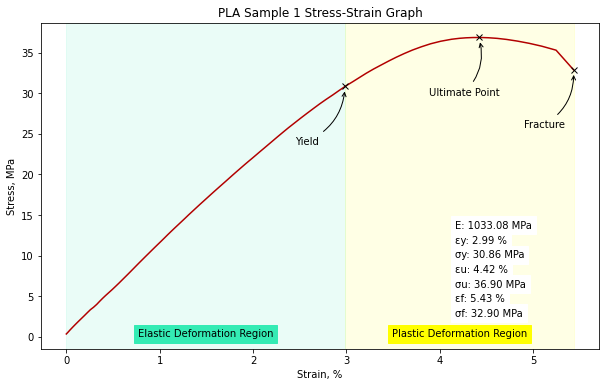

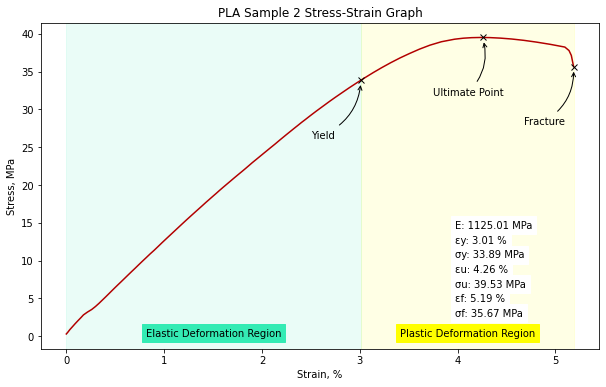

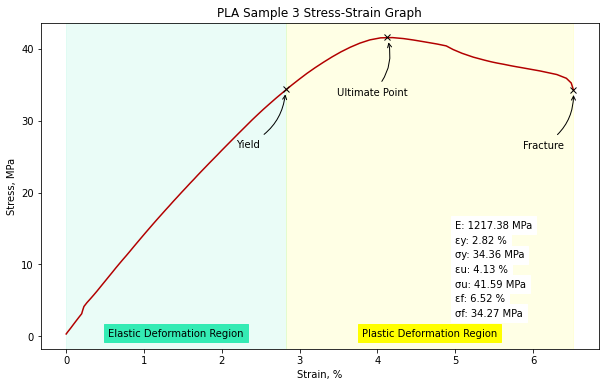

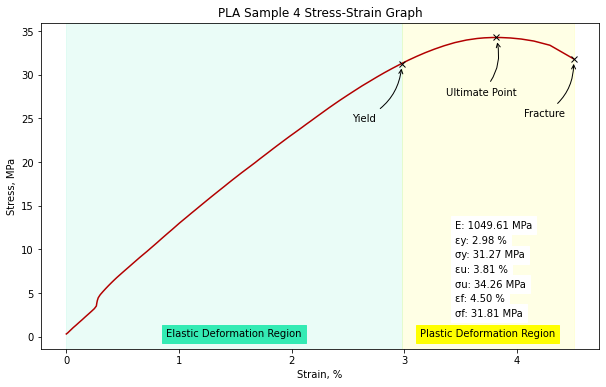

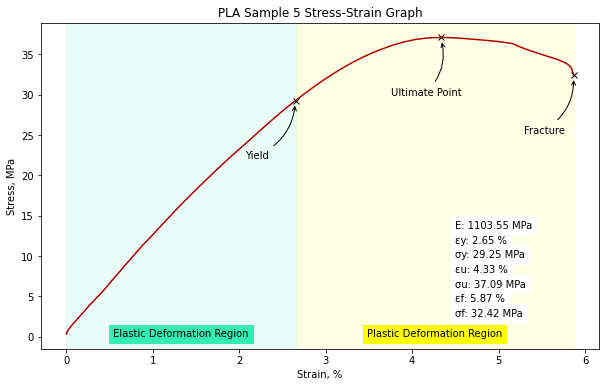

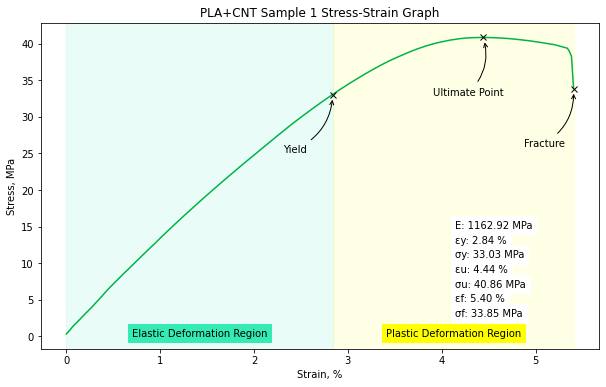

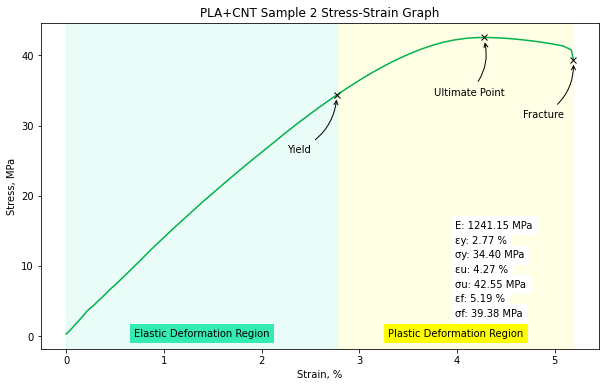

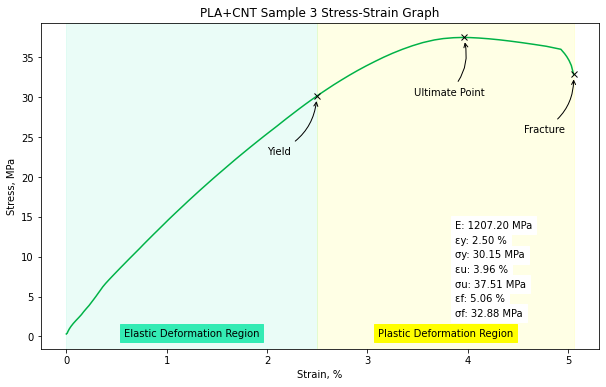

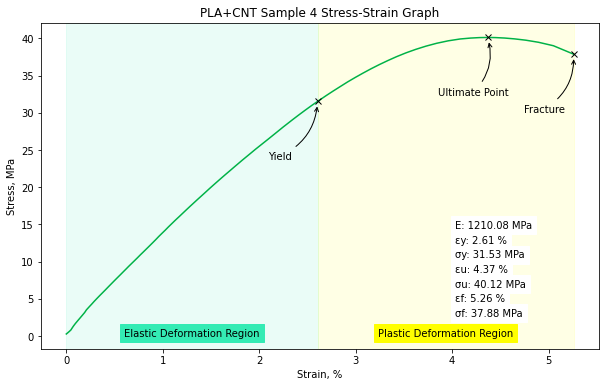

In [167]:
figsize=(10,6)

subfolder = 'tensile_graph'

if not os.path.exists(os.path.join(EXPORT_OUTPUT_PATH, subfolder)):
  os.mkdir(os.path.join(EXPORT_OUTPUT_PATH, subfolder))

for i_df in df_collection:
  fig, ax = plt.subplots()
  # ax.spines['left'].set_position('zero')
  # ax.spines['bottom'].set_position('zero')

  i_df.df.plot(
      ax=ax,
      x='Strain',
      xlabel='Strain, %', 
      ylabel='Stress, MPa', 
      title= f'{i_df.name} Stress-Strain Graph', 
      figsize=figsize,
      color=color_dict[i_df.specimen_type],
      legend=False
      )
  
  eval_metric = {
      'Ultimate Point': (i_df.statistics['eM'], i_df.statistics['sM']),
      # 'Yield Point': ((i_df.statistics['sY'] * 100 / i_df.statistics['Et']), i_df.statistics['sY']); Discrepancy in Data, where tensile-yield == tensile-ultimate
      'Yield': (i_df.statistics['eY_calc'], i_df.statistics['sY_calc']),
      'Fracture': (i_df.statistics['eB'], i_df.statistics['sB']),
  }

  for k, v in eval_metric.items():
    plt.plot([v[0]], [v[1]], marker='x', c='black')
    # ax.annotate(f'{k}\nstrain {v[0]:.2f} \nstress {v[1]:.2f}', 
    ax.annotate(f'{k}', 
                [v[0], v[1]],
                xytext=(-50,-50), 
                textcoords='offset points',
                arrowprops=dict(
                    facecolor='black', 
                    arrowstyle="->",
                    shrinkA=5, 
                    shrinkB=5,
                    connectionstyle="arc3,rad=0.3"
                    ), 
                horizontalalignment='left', 
                verticalalignment='top'
                )
    

  eval_region = {
      'Elastic Deformation Region': (0, i_df.statistics['eY_calc'], '#34ebb4'),
      'Plastic Deformation Region': (i_df.statistics['eY_calc'], i_df.statistics['eB'], 'yellow'),
  }
  for k, v in eval_region.items():
    ax.axvspan(v[0], v[1], 
               alpha=.1,
               color=v[2],
               )
    
    plt.annotate(k, 
              xy=(v[0], 1),  
              xycoords='data',
              xytext=((v[0]+v[1])/2,0),
              textcoords='data',
              horizontalalignment='center', 
              backgroundcolor = v[2],
              )
  # plt.plot([0, i_df.statistics['eY_calc']], [0, i_df.statistics['sY_calc']], linestyle=':')
  # plt.plot([0, i_df.statistics['eY_calc']], [np.sqrt(MAX_ERROR), i_df.statistics['sY_calc']+np.sqrt(MAX_ERROR)], marker='')


  # plt.plot([0, (i_df.statistics['sY'] * 100 / i_df.statistics['Et'])], [0, i_df.statistics['sY']], marker='')
  # ax.annotate(f'Modulus Young\n {i_df.name}', 
  #             [(i_df.statistics['sY'] * 100 / i_df.statistics['Et']), i_df.statistics['sY']],
  #             xytext=(-35,-40), 
  #             textcoords='offset points', 
  #             )
  
  stats_to_show = {
      'sB': 'σf', 
      'eB': 'εf', 
      'sM': 'σu', 
      'eM': 'εu', 
      'sY_calc': 'σy', 
      'eY_calc': 'εy',
      'Et_calc': 'E', 
      }
  for n, stat in enumerate(stats_to_show):
    text = i_df.statistics[stat]
    plt.figtext(.7, .2 + (.034*n), f'{stats_to_show[stat]}: {text:.2f} {i_df.statistics_unit_ref[stat]}', backgroundcolor='white')
  if SAVE_AND_DOWNLOAD_FIGURES:
    plt.savefig(os.path.join(EXPORT_OUTPUT_PATH, subfolder, f'{i_df.name}_graph.png'), dpi=300)
  plt.show()  
  

---

## Plotting all tensile strength graphs as bar chart

---

In [168]:
stats_to_show = {
    'sB': 'Failure Stress σf', 
    'eB': 'Failure Strain εf', 
    'sM': 'Ultimate Stress σu', 
    'eM': 'Ultimate Strain εu', 
    'sY_calc': 'Yield Stess σy', 
    'eY_calc': 'Yield Strain εy',
    'Et_calc': 'Modulus Young E', 
    }

y_axis_dict = {
    'sB': 'Stress', 
    'eB': 'Strain', 
    'sM': 'Stress', 
    'eM': 'Strain', 
    'sY_calc': 'Stress', 
    'eY_calc': 'Strain',
    'Et_calc': 'Modulus Young', 
    }

ylim_per_stat = {
    'sB': [0,0], 
    'eB': [0,0], 
    'sM': [0,0], 
    'eM': [0,0], 
    'sY_calc': [0,0], 
    'eY_calc': [0,0],
    'Et_calc': [0,0], 
    }

In [169]:
# Set plot ylim limits

temp_lim_dict = {}
unique = ""
for cat in y_axis_dict:
  temp_lim_dict[y_axis_dict[cat]] = [[], []]

def ceil(n):
  if n == int(n):
    return n
  else:
    return int(n) + 1

def floor(n):
  if n == int(n):
    return n
  else:
    return int(n)

for cat in stats_to_show:
  temp_values = []
  # get df types
  for i_df in df_collection:
    temp_values.append(i_df.statistics[cat])
  ylim_per_stat[cat][0] = floor(min(temp_values))
  ylim_per_stat[cat][1] = ceil(max(temp_values))


for cat in ylim_per_stat:
  temp_lim_dict[y_axis_dict[cat]][0].append(ylim_per_stat[cat][0])
  temp_lim_dict[y_axis_dict[cat]][1].append(ylim_per_stat[cat][1])

for cat in ylim_per_stat:
  lower_lim = min(temp_lim_dict[y_axis_dict[cat]][0])
  upper_lim = max(temp_lim_dict[y_axis_dict[cat]][1])
  # maxval_ceil = maxval + 10 - (maxval % 10)
  diff = upper_lim - lower_lim
  ylim_per_stat[cat][0] = lower_lim - floor(diff/3)
  ylim_per_stat[cat][1] = upper_lim + ceil(diff/3)
  print(cat, diff, lower_lim, upper_lim)
  
  
print(temp_lim_dict)
print(ylim_per_stat)


del temp_lim_dict

sB 14 29 43
eB 5 2 7
sM 14 29 43
eM 5 2 7
sY_calc 14 29 43
eY_calc 5 2 7
Et_calc 209 1033 1242
{'Stress': [[31, 34, 29], [40, 43, 35]], 'Strain': [[4, 3, 2], [7, 5, 4]], 'Modulus Young': [[1033], [1242]]}
{'sB': [25, 48], 'eB': [1, 9], 'sM': [25, 48], 'eM': [1, 9], 'sY_calc': [25, 48], 'eY_calc': [1, 9], 'Et_calc': [964, 1312]}


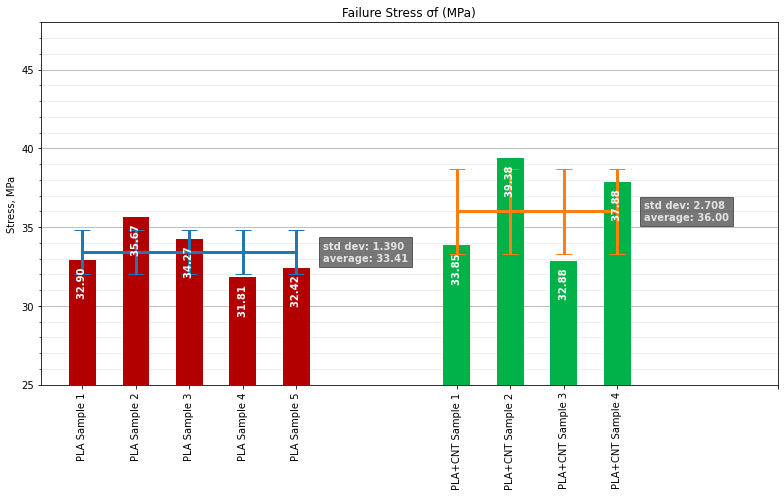

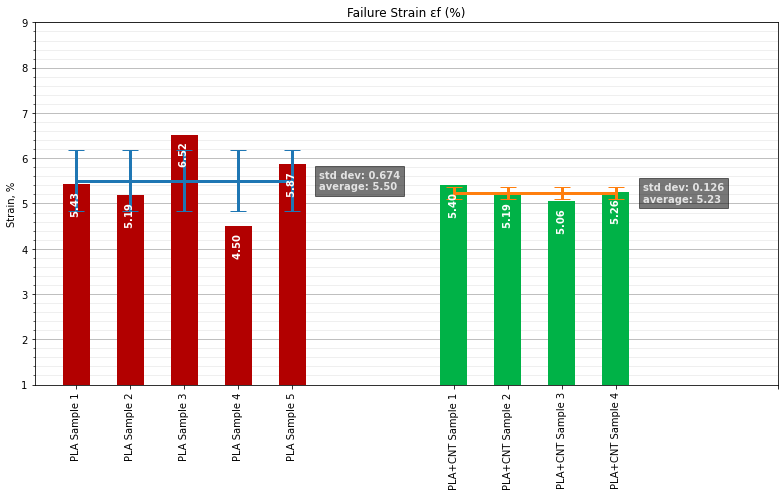

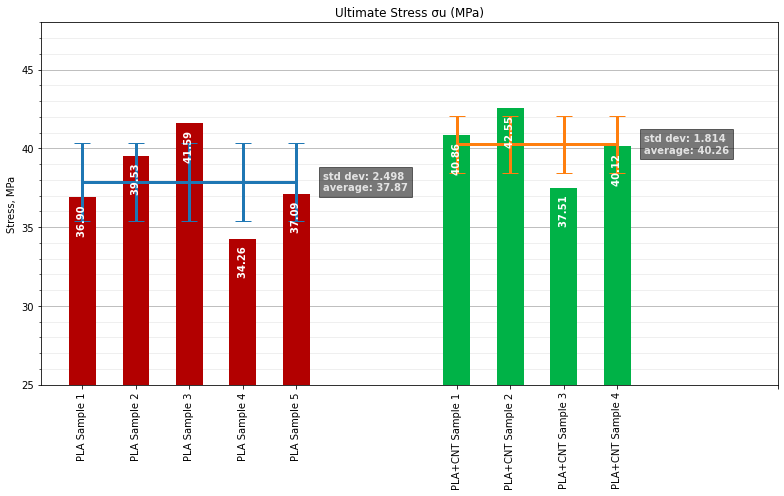

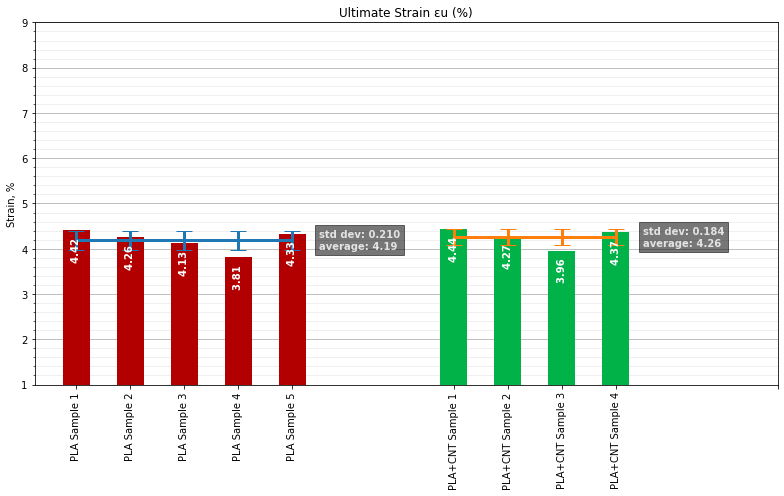

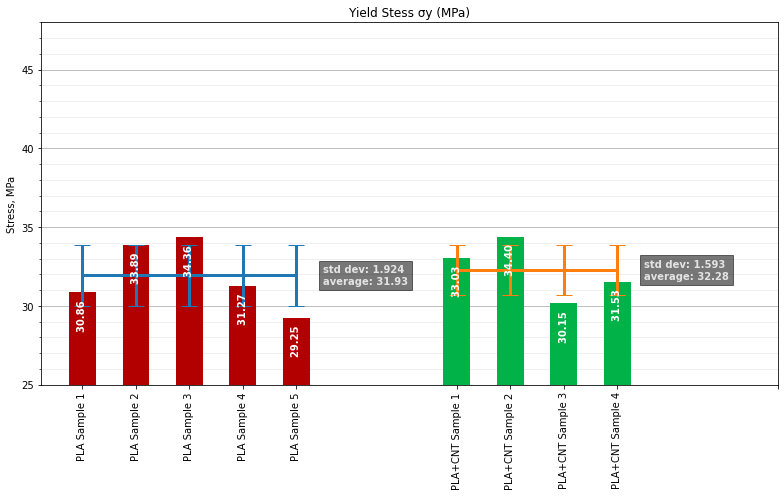

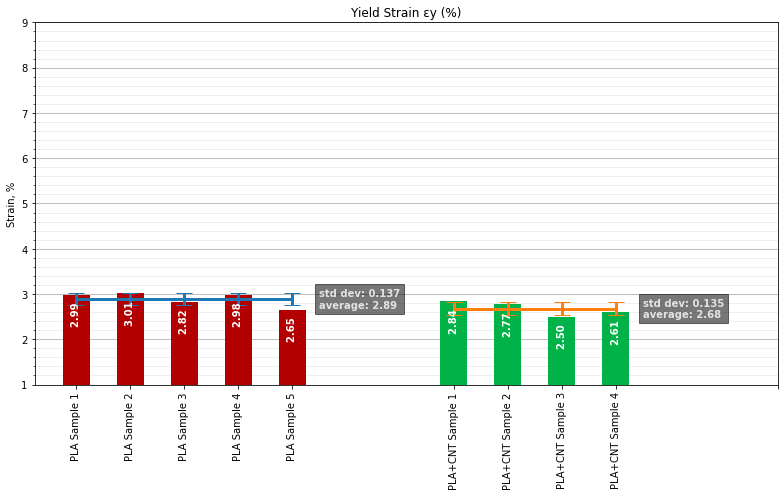

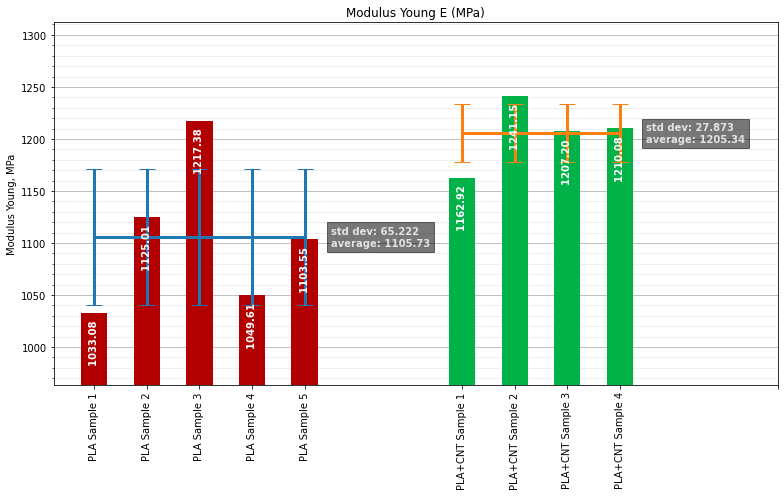

In [170]:
figsize=(11,7)

subfolder = 'compiled_bar_chart'

if not os.path.exists(os.path.join(EXPORT_OUTPUT_PATH, subfolder)):
  os.mkdir(os.path.join(EXPORT_OUTPUT_PATH, subfolder))

for cat in stats_to_show:
  temp_values = {}
  # get df types
  for i_df in df_collection:
    if i_df.specimen_type not in temp_values:
      temp_values[i_df.specimen_type] = {'key':[], 'val':[]}
    temp_values[i_df.specimen_type]['key'].append(i_df.name)
    temp_values[i_df.specimen_type]['val'].append(i_df.statistics[cat])

  fig, ax = plt.subplots(figsize=figsize)
  ax.set_axisbelow(True)
  ax.set_ylabel(f'{y_axis_dict[cat]}, {i_df.statistics_unit_ref[cat]}')
  ax.set_title(f'{stats_to_show[cat]} ({i_df.statistics_unit_ref[cat]})')
    
  offset_list = []
  key_list = []
  width = .4
  last_offset = 0
  padding = .2
  total_len = 0

  for i in temp_values:
    for j in temp_values[i]['key']:
      total_len += width
  
  y_temp_min, y_temp_max = [0,0]
  # for s_type in temp_values:
  #   if cat.startswith('s'):
  #     ylim = (25,max(val) + 5)
  #   elif cat.startswith('E'):
  #     ylim = (900,max(val) + 30) 
  for s_type in temp_values:


    key = np.array(temp_values[s_type]['key'])
    val = np.array(temp_values[s_type]['val'])
    std_dev = np.std(val)
    val_avg = np.average(val)

    # ylim = (2,max(val) + 2)
    # if cat.startswith('s'):
    #   ylim = (25,max(val) + 5)
    # elif cat.startswith('E'):
    #   ylim = (900,max(val) + 30)
    ax.set_ylim(ylim_per_stat[cat])


    offset = [(width*i) + last_offset for i in range(len(temp_values[s_type]['key']))]
    last_offset = max(offset) + width + padding * 4
    offset_list += offset
    key_list += temp_values[s_type]['key']
    plt.bar(offset, temp_values[s_type]['val'], width = width - padding, color=color_dict[s_type])
    
    # xmin = min(offset)/total_len
    # xmax = max(offset)/total_len
    # ax.axhline(val_avg, xmin=xmin, xmax = xmax)

    for id, of in enumerate(offset):
      plt.text(of, val[id], f'{val[id]:.2f}  ', rotation=90, color='white', verticalalignment='top', horizontalalignment='center', fontweight='heavy')
    plt.text(max(offset)+padding, val_avg, f'std dev: {std_dev:.3f}\naverage: {val_avg:.2f}', verticalalignment='center', backgroundcolor='#00000088', color='white', alpha=.8, fontweight='heavy')

    plt.errorbar(offset, [val_avg for i in range(len(offset))], yerr=[std_dev for i in range(len(offset))], capsize=8, linewidth = 3)
    plt.xticks(offset_list, key_list, rotation=90, in_layout=True)


  ax.set_xticks(list(ax.get_xticks()) + [max(list(ax.get_xticks()))+1.2])
  plt.grid(axis='y', which='major', zorder=0)
  plt.grid(axis='y', which='minor', zorder=0, color='#ebebeb')
  ax.xaxis.set_tick_params(which='minor', bottom=False)
  plt.minorticks_on()
  fig.tight_layout()
  if SAVE_AND_DOWNLOAD_FIGURES:
    plt.savefig(os.path.join(EXPORT_OUTPUT_PATH, subfolder, f'{subfolder}_{cat}'))
  plt.show()
    

---
## Download graphs
---

In [171]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

if os.path.exists(EXPORT_OUTPUT_PATH):
  list_files(EXPORT_OUTPUT_PATH)

export/
    tensile_graph/
        PLA Sample 2_graph.png
        PLA+CNT Sample 3_graph.png
        PLA Sample 4_graph.png
        PLA Sample 1_graph.png
        PLA+CNT Sample 4_graph.png
        PLA Sample 3_graph.png
        PLA Sample 5_graph.png
        PLA+CNT Sample 1_graph.png
        PLA+CNT Sample 2_graph.png
    bar_chart/
    temp_grad_plot_eval/
        Linear to Actual Curve PLA+CNT Sample 3.png
        Linear to Actual Curve PLA Sample 4.png
        Linear to Actual Curve PLA+CNT Sample 2.png
        Linear to Actual Curve PLA+CNT Sample 4.png
        Linear to Actual Curve PLA Sample 2.png
        Linear to Actual Curve PLA+CNT Sample 1.png
        Linear to Actual Curve PLA Sample 3.png
        Linear to Actual Curve PLA Sample 1.png
        Linear to Actual Curve PLA Sample 5.png
    compiled_bar_chart/
        compiled_bar_chart_sY_calc.png
        compiled_bar_chart_eM.png
        compiled_bar_chart_eB.png
        compiled_bar_chart_sB.png
        compiled_bar_char

In [172]:
!zip -r /content/results.zip /content/export

  adding: content/export/ (stored 0%)
  adding: content/export/tensile_graph/ (stored 0%)
  adding: content/export/tensile_graph/PLA Sample 2_graph.png (deflated 14%)
  adding: content/export/tensile_graph/PLA+CNT Sample 3_graph.png (deflated 14%)
  adding: content/export/tensile_graph/PLA Sample 4_graph.png (deflated 14%)
  adding: content/export/tensile_graph/PLA Sample 1_graph.png (deflated 14%)
  adding: content/export/tensile_graph/PLA+CNT Sample 4_graph.png (deflated 14%)
  adding: content/export/tensile_graph/PLA Sample 3_graph.png (deflated 14%)
  adding: content/export/tensile_graph/PLA Sample 5_graph.png (deflated 14%)
  adding: content/export/tensile_graph/PLA+CNT Sample 1_graph.png (deflated 14%)
  adding: content/export/tensile_graph/PLA+CNT Sample 2_graph.png (deflated 14%)
  adding: content/export/bar_chart/ (stored 0%)
  adding: content/export/temp_grad_plot_eval/ (stored 0%)
  adding: content/export/temp_grad_plot_eval/Linear to Actual Curve PLA+CNT Sample 3.png (defla

In [173]:
if SAVE_AND_DOWNLOAD_FIGURES:
  files.download("/content/results.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>